In [1]:
#!pip install sktime
#!pip install giotto-tda
#!pip install openml

In [2]:
import openml

In [3]:
%matplotlib inline

In [4]:
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
### our imports

from src.utils import *
from src.TFE import *
from src import *

In [5]:
#!wget -nc "http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_arff.zip"
#!unzip -q -n "Univariate2018_arff.zip"

In [6]:
directory_list = get_files_directory_list()
directory_list = sorted(directory_list)

random_index =  111
random_path = directory_list[random_index]

X_train, X_test, y_train, y_test = get_data_from_directory(random_path)
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()
num_classes = np.unique(y_train).shape[0]

print('Dataset: ', random_path)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape:  ', X_test.shape)
print('y_test shape:  ', y_test.shape)
print('num. of class: ', num_classes)

Dataset:  Symbols
X_train shape:  (25, 398)
y_train shape:  (25,)
X_test shape:   (995, 398)
y_test shape:   (995,)
num. of class:  6


In [7]:
%%time

feature_extractor = TopologicalFeaturesExtractor(
    persistence_diagram_extractor=PersistenceDiagramsExtractor(tokens_embedding_dim=2, 
                                                               tokens_embedding_delay=3,
                                                               homology_dimensions=(0, 1),
                                                               parallel=True),
    persistence_diagram_features=[HolesNumberFeature(),
                                  MaxHoleLifeTimeFeature(),
                                  RelevantHolesNumber(),
                                  AverageHoleLifetimeFeature(),
                                  SumHoleLifetimeFeature(),
                                  PersistenceEntropyFeature(),
                                  SimultaneousAliveHolesFeatue(),
                                  AveragePersistenceLandscapeFeature(),
                                  BettiNumbersSumFeature(),
                                  RadiusAtMaxBNFeature()])

X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.fit_transform(X_test)

CPU times: user 1min 44s, sys: 9.44 s, total: 1min 54s
Wall time: 2min 13s


In [8]:
print('X_train_transformed shape: ', X_train_transformed.shape)
print('X_test_transformed shape:  ', X_test_transformed.shape)

X_train_transformed shape:  (25, 19)
X_test_transformed shape:   (995, 19)


In [9]:
class Experiment:
    def __init__(self, model, parameters_grid, cv, scoring, n_jobs = -1):
        self.model = model
        self.parameters = parameters_grid
        self.cv = cv 
        self.scoring = scoring,
        self.jobs = n_jobs
        
    def GridSearchFit(self, X_train_transformed, y_train, y_test):
        self.model_cv = GridSearchCV(self.model, param_grid = self.parameters, cv = self.cv, 
                                    scoring = self.scoring, n_jobs = self.jobs)
        self.model_cv.fit(X_train_transformed, y_train)
        return accuracy_score(y_test, self.model_cv.best_estimator_.predict(X_test_transformed))

In [10]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}

svc_cv = GridSearchCV(SVC(random_state=42), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)
svc_cv.fit(X_train_transformed, y_train)

print("Train accuracy: ", accuracy_score(y_train, svc_cv.best_estimator_.predict(X_train_transformed)))
print("Test accuracy: ", accuracy_score(y_test, svc_cv.best_estimator_.predict(X_test_transformed)))

Train accuracy:  0.92
Test accuracy:  0.44321608040201005


In [11]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
svc_cv = GridSearchCV(XGBClassifier(n_jobs=-1, random_state=42), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)
svc_cv.fit(X_train_transformed, y_train)

print("Train accuracy: ", accuracy_score(y_train, svc_cv.best_estimator_.predict(X_train_transformed)))
print("Test accuracy: ", accuracy_score(y_test, svc_cv.best_estimator_.predict(X_test_transformed)))

Train accuracy:  1.0
Test accuracy:  0.7557788944723618


In [12]:
parameters = {"n_neighbors": [3, 5, 7, 11,]}

knn_cv = GridSearchCV(KNeighborsClassifier(n_jobs=-1), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)
knn_cv.fit(X_train_transformed, y_train)

print("Train accuracy: ", accuracy_score(y_train, knn_cv.best_estimator_.predict(X_train_transformed)))
print("Test accuracy: ", accuracy_score(y_test, knn_cv.best_estimator_.predict(X_test_transformed)))

Train accuracy:  0.68
Test accuracy:  0.29246231155778896


In [13]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250],
              "early_stopping_rounds": [2, 5, 8, 10, 50, 200]}


cat_cv = GridSearchCV(CatBoostClassifier(random_state=42, verbose=False), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)

cat_cv.fit(X_train_transformed, y_train)

print('Dataset: ', random_path)
print("Train accuracy: ", accuracy_score(y_train, cat_cv.best_estimator_.predict(X_train_transformed)))
print("Test accuracy: ", accuracy_score(y_test, cat_cv.best_estimator_.predict(X_test_transformed)))

Dataset:  Symbols
Train accuracy:  1.0
Test accuracy:  0.7507537688442211


In [14]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

device = get_device()
batch_size = 32
latent_dim = num_classes * 4

In [15]:
scale = StandardScaler()
scale.fit(X_train_transformed)

X_train_transformed_dim = handle_dim(X_train_transformed, scale)
X_test_transformed_dim = handle_dim(X_test_transformed, scale)

y_hot_train = one_hot_encoding(y_train)
y_hot_test = one_hot_encoding(y_test)

dataset_train = TimeSeriesDataLoader(X_train_transformed_dim, y_hot_train, batch_size)
dataset_test = TimeSeriesDataLoader(X_test_transformed_dim, y_hot_test, batch_size)

test_data = torch.zeros(dataset_train.dataset[:][0].shape)
test_data.shape

torch.Size([25, 1, 19])

In [16]:
vae = VariationalAutoencoder(batch_size=batch_size, latent_dims=latent_dim, test_data=test_data)
vae = vae.to(device)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=2e-3, weight_decay=1e-5)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 23633


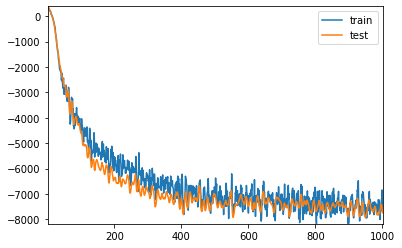

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (fc_mu): Linear(in_features=256, out_features=24, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=24, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=24, out_features=96, bias=True)
    (conv2): ConvTranspose1d(32, 1, kernel_size=(15,), stride=(3,), padding=(1,))
  )
)

In [17]:
train_AE(1000, vae, dataset_train, dataset_test, optimizer, device, verbose=True)

In [18]:
from_vae_loader2numpy = lambda model, x: model.transform(x.dataset[:][0]).cpu().detach().numpy()

In [19]:
z_train = from_vae_loader2numpy(vae, dataset_train)
z_test = from_vae_loader2numpy(vae, dataset_test)

In [20]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
svc_cv = GridSearchCV(XGBClassifier(n_jobs=-1, random_state=42), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)
svc_cv.fit(z_train, y_train)

print('Dataset: ', random_path)
print("Train accuracy: ", accuracy_score(y_train, svc_cv.best_estimator_.predict(z_train)))
print("Test accuracy: ", accuracy_score(y_test, svc_cv.best_estimator_.predict(z_test)))

Dataset:  Symbols
Train accuracy:  1.0
Test accuracy:  0.6371859296482412


In [21]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}

svc_cv = GridSearchCV(SVC(random_state=42), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)
svc_cv.fit(z_train, y_train)

print('Dataset: ', random_path)
print("Train accuracy: ", accuracy_score(y_train, svc_cv.best_estimator_.predict(z_train)))
print("Test accuracy: ", accuracy_score(y_test, svc_cv.best_estimator_.predict(z_test)))

Dataset:  Symbols
Train accuracy:  1.0
Test accuracy:  0.8020100502512563


In [22]:
parameters = {"n_neighbors": [1, 2, 3, 5, 7, 11,]}

knn_cv = GridSearchCV(KNeighborsClassifier(n_jobs=-1), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)
knn_cv.fit(z_train, y_train)

print('Dataset: ', random_path)
print("Train accuracy: ", accuracy_score(y_train, knn_cv.best_estimator_.predict(z_train)))
print("Test accuracy: ", accuracy_score(y_test, knn_cv.best_estimator_.predict(z_test)))

Dataset:  Symbols
Train accuracy:  0.92
Test accuracy:  0.6623115577889447


In [23]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250],
              "early_stopping_rounds": [2, 5, 8, 10, 50, 200]}


cat_cv = GridSearchCV(CatBoostClassifier(random_state=42, verbose=False), 
                      param_grid=parameters,
                      cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                      scoring='accuracy', 
                      n_jobs=-1)

cat_cv.fit(z_train, y_train)

print('Dataset: ', random_path)
print("Train accuracy: ", accuracy_score(y_train, cat_cv.best_estimator_.predict(z_train)))
print("Test accuracy: ", accuracy_score(y_test, cat_cv.best_estimator_.predict(z_test)))

Dataset:  Symbols
Train accuracy:  1.0
Test accuracy:  0.6984924623115578


In [24]:
neural_net_params = {'in_features=latent_dim': latent_dim,
                         'out_features': num_classes,
                         'depth': 4}

net = ANN(latent_dim, num_classes, device)
net.fit(z_train, y_train)

y_train_pred = net.predict(z_train)
y_test_pred = net.predict(z_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

/home/samir/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/home/samir/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/home/samir/Desktop/repositories/Time-Series-Classification/src/utils.py:84: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

